In [1]:
from collections import namedtuple
from io import StringIO
from typing import Iterator, Tuple

import ase
import ase.io
import jax
import jax.numpy as jnp
import jraph
import matplotlib.pyplot as plt
import matscipy.neighbours
import numpy as np

In [2]:
NodesInfo = namedtuple("NodesInfo", ["positions", "atomic_numbers"])


def ase_atoms_to_jraph_graph(atoms: ase.Atoms, cutoff: float) -> jraph.GraphsTuple:
    receivers, senders = matscipy.neighbours.neighbour_list(
        quantities="ij",
        positions=atoms.positions,
        cutoff=cutoff,
    )

    return jraph.GraphsTuple(
        nodes=NodesInfo(atoms.positions, atoms.numbers),
        edges=None,
        globals=None,
        senders=senders,
        receivers=receivers,
        n_node=np.array([len(atoms)]),
        n_edge=np.array([len(senders)]),
    )


In [3]:
def draw_graph(
    positions: jnp.ndarray,
    senders: jnp.ndarray,
    receivers: jnp.ndarray,
    node_color: jnp.ndarray = None,
    edge_color: jnp.ndarray = None,
):
    positions -= positions.mean(axis=0)

    if len(positions) > 1:
        cov = np.cov(positions.T)
        _, v = jnp.linalg.eigh(cov)
        positions = positions @ v

    if edge_color is None:
        edge_color = jnp.zeros_like(senders)
    if node_color is None:
        node_color = jnp.zeros_like(positions[:, 0])

    edge_color = edge_color.astype(jnp.float32)

    plt.scatter(positions[:, 1], positions[:, 2], c=node_color, cmap="tab10", zorder=2, s=100)
    plt.axis("equal")
    for s, r, c in zip(senders, receivers, edge_color):
        c = plt.cm.tab10(c)
        plt.plot(positions[[s, r], 1], positions[[s, r], 2], zorder=1, color=c)


In [4]:
def subgraph(graph: jraph.GraphsTuple, nodes: np.ndarray) -> jraph.GraphsTuple:
    """Extract a subgraph from a graph.

    Args:
        graph: The graph to extract a subgraph from.
        nodes: The indices of the nodes to extract.

    Returns:
        The subgraph.
    """
    assert len(graph.n_edge) == 1 and len(graph.n_node) == 1, "Only single graphs supported."

    # Find all edges that connect to the nodes.
    edges = np.isin(graph.senders, nodes) & np.isin(graph.receivers, nodes)

    new_node_indices = -np.ones(graph.n_node[0], dtype=int)
    new_node_indices[nodes] = np.arange(len(nodes))

    return jraph.GraphsTuple(
        nodes=jax.tree_util.tree_map(lambda x: x[nodes], graph.nodes),
        edges=jax.tree_util.tree_map(lambda x: x[edges], graph.edges),
        globals=graph.globals,
        senders=new_node_indices[graph.senders[edges]],
        receivers=new_node_indices[graph.receivers[edges]],
        n_node=np.array([len(nodes)]),
        n_edge=np.array([np.sum(edges)]),
    )

In [5]:
GlobalsInfo = namedtuple("GlobalsInfo", ["stop", "target_position", "target_atomic_number"])


def generative_sequence(rng: jnp.ndarray, graph: jraph.GraphsTuple, epsilon: float = 0.01) -> Iterator[jraph.GraphsTuple]:
    """Generative sequence for a molecular graph.

    Args:
        rng: The random number generator.
        graph: The molecular graph.
        epsilon: Tolerance for the nearest neighbours.

    Returns:
        A generator that yields the next subgraph.
        - The globals are:
            - a boolean indicating whether the molecule is complete
            - the target position and atomic number
        - The last node is the focus node.
    """
    assert len(graph.n_edge) == 1 and len(graph.n_node) == 1, "Only single graphs supported."
    assert graph.n_node[0] >= 2, "Graph must have at least two nodes."

    vectors = graph.nodes.positions[graph.receivers] - graph.nodes.positions[graph.senders]
    dist = np.linalg.norm(vectors, axis=1)  # [n_edge]

    # pick a random initial node
    rng, k = jax.random.split(rng)
    first_node = jax.random.randint(k, shape=(), minval=0, maxval=graph.n_node[0])

    min_dist = dist[graph.senders == first_node].min()
    targets = graph.receivers[(graph.senders == first_node) & (dist < min_dist + epsilon)]

    # pick a random target
    rng, k = jax.random.split(rng)
    target = jax.random.choice(k, targets, shape=())

    globals = GlobalsInfo(
        stop=jnp.array([False], dtype=bool),  # [1]
        target_position=graph.nodes.positions[target][None],  # [1, 3]
        target_atomic_number=graph.nodes.atomic_numbers[target][None],  # [1]
    )
    yield subgraph(graph, jnp.array([first_node]))._replace(globals=globals)

    visited = jnp.array([first_node, target])

    for _ in range(graph.n_node[0] - 2):
        mask = jnp.isin(graph.senders, visited) & ~jnp.isin(graph.receivers, visited)
        min_dist = dist[mask].min()

        maks = mask & (dist < min_dist + epsilon)
        i = jnp.where(maks)[0]
        
        # pick a random edge
        rng, k = jax.random.split(rng)
        edge = jax.random.choice(k, i, shape=())

        focus_node = graph.senders[edge]
        target_node = graph.receivers[edge]

        globals = GlobalsInfo(
            stop=jnp.array([False], dtype=bool),  # [1]
            target_position=graph.nodes.positions[target_node][None],  # [1, 3]
            target_atomic_number=graph.nodes.atomic_numbers[target_node][None],  # [1]
        )
        yield subgraph(graph, visited)._replace(globals=globals)

        visited = jnp.concatenate([visited, jnp.array([target_node])])

    globals = GlobalsInfo(
        stop=jnp.array([True], dtype=bool),  # [1]
        target_position=jnp.zeros((1, 3)),  # [1, 3]
        target_atomic_number=jnp.array([0], dtype=int),  # [1]
    )
    yield graph._replace(globals=globals)

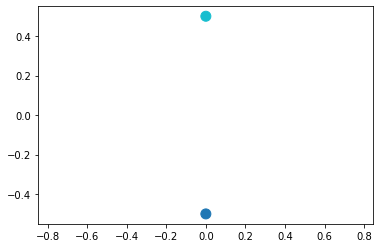

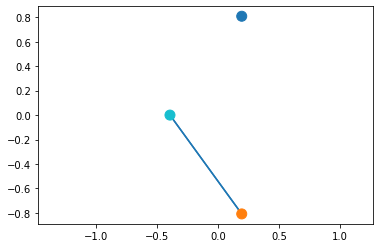

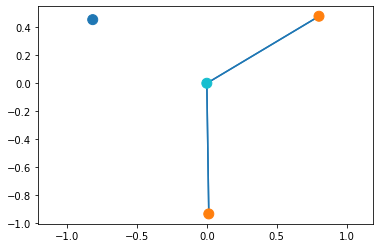

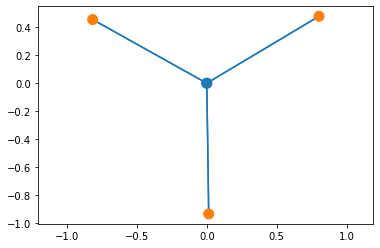

In [6]:
ammonia = ase.io.read(
    StringIO(
        """4
Azane
  N     -0.0353     -0.0440      0.0285
  H      0.2658      0.6496      0.6822
  H      0.7774     -0.4532     -0.3850
  H     -0.5522      0.4148     -0.6935
"""
    ),
    format="xyz",
)
ammonia = ase_atoms_to_jraph_graph(ammonia, cutoff=1.5)


for graph in generative_sequence(jax.random.PRNGKey(1), ammonia):
    plt.figure()
    draw_graph(
        jnp.concatenate([graph.nodes.positions, graph.globals.target_position]),
        graph.senders,
        graph.receivers,
        node_color=jnp.concatenate([graph.nodes.atomic_numbers, jnp.array([0])]),
    )


In [7]:
ammonia

GraphsTuple(nodes=NodesInfo(positions=array([[-0.0353, -0.044 ,  0.0285],
       [ 0.2658,  0.6496,  0.6822],
       [ 0.7774, -0.4532, -0.385 ],
       [-0.5522,  0.4148, -0.6935]]), atomic_numbers=array([7, 1, 1, 1])), edges=None, receivers=array([0, 0, 0, 1, 2, 3], dtype=int32), senders=array([1, 2, 3, 0, 0, 0], dtype=int32), globals=None, n_node=array([4]), n_edge=array([6]))